In [74]:
import xarray as xr
import numpy as np
import more_itertools as mit
import glob
import datetime as dt 
#import vor_fast
#import vor_fast_setup
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from scipy import stats
import statsmodels.api as sm
from string import ascii_lowercase, ascii_uppercase

from tqdm.auto import tqdm

In [2]:
def mode_func(aspect, latcent):
    #for latcent, cube the values to transform the distribution
    latcent3=np.power(latcent,3)
    #fit Gaussian distribution and use KS test for fit
    dist=getattr(stats,'norm')
    parameters=dist.fit(latcent3)
    (mean,SD)=parameters
    ks_stat,ks_pval=stats.kstest(latcent3,"norm",parameters)
    # convert latitude back (cube root)
    mode=np.power(mean,1/3)

    print('latcent mode:',mode)
    print('norm KS statistic and p value:',ks_stat,ks_pval)

    #fit GEV to aspect data
    dist2=getattr(stats,'genextreme')
    parameters=dist2.fit(aspect)
    (shape,location,scale)=parameters
    ks_stat_GEV,ks_pval_GEV = stats.kstest(aspect,"genextreme",parameters)

    print('location:', location)
    print(' GEV KS statistic and p value:',ks_stat_GEV,ks_pval_GEV)

    #aspect mode calculated according to Seviour et al. 2016 (S16)
    asp_params=stats.genextreme.fit(aspect)
    asp_pdf=stats.genextreme.pdf(aspect,asp_params[0],loc=asp_params[1],scale=asp_params[2])
    index=np.argmax(asp_pdf)
    max_asp_S16=aspect[index]

    print ('S16 aspect:',max_asp_S16)

    #kde alternative
    # aspect
    min_val=1
    max_val=int(np.round(np.max(aspect))+1)
    
    divs=(max_val-min_val)*100
    
    asp_xs=np.linspace(min_val,max_val,divs)
    asp_density=stats.gaussian_kde(aspect)
    asp_ys=asp_density(asp_xs)
    index=np.argmax(asp_ys)
    max_asp_kde=asp_xs[index]

    #latcent
    min1=int(np.round(np.min(latcent))-1)
    max1=90
    divs1=(max1-min1)*100

    lat_xs=np.linspace(min1,max1,divs1)
    lat_density=stats.gaussian_kde(latcent)
    lat_ys=lat_density(lat_xs)
    index1=np.argmax(lat_ys)
    max_lat_kde=lat_xs[index1]

    print ('kde aspect:',max_asp_kde)
    print ('kde latcent:',max_lat_kde)
    
    return max_asp_S16,mode

def diff_list(x, wo_x):
    return list(set(x) - set(wo_x))

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Constants

In [10]:
plt.rcParams.update({'font.size': 28, "contour.linewidth": 4})
root_path = '/work/bd1022/b381258/CMIP6/including_April/'
time_dict = dict(time = slice('1979-01',None))
out_dir = './SSWs_stats/'

In [4]:
filepaths1=[]
for filepath1 in glob.iglob(f'{root_path}*ua*MPI-ESM1-2-LR-all*'):
    filepaths1.append(filepath1)
filepaths1.sort()

# filepaths to obtain 10hPa GPH for northern hemisphere
filepaths2=[]
for filepath2 in glob.iglob(f'{root_path}*MPI-ESM1-2-LR-all-from1979*moments*'):
    filepaths2.append(filepath2)
filepaths2.sort()

In [15]:
filepaths1

['/work/bd1022/b381258/CMIP6/including_April/ua_day_MPI-ESM1-2-LR-all_historical_@10hPa_1979-2014.nc']

In [16]:
filepaths2

['/work/bd1022/b381258/CMIP6/including_April/MPI-ESM1-2-LR-all-from1979_moments@10hPa.nc']

# SSW frequency

Code adopted from [Hall et al (2021)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JD034759).

In [47]:
moments

<xarray.Dataset>
Dimensions:             (member_id: 17, dcpp_init_year: 1, time: 6480)
Coordinates:
  * time                (time) object 1979-01-01 12:00:00 ... 2014-12-30 12:0...
    plev                float64 ...
  * dcpp_init_year      (dcpp_init_year) float64 nan
  * member_id           (member_id) object 'r10i1p1f2' ... 'r9i1p1f2'
Data variables:
    angle               (member_id, dcpp_init_year, time) float64 ...
    aspect_ratio        (member_id, dcpp_init_year, time) float64 ...
    objective_area      (member_id, dcpp_init_year, time) float64 ...
    kurtosis            (member_id, dcpp_init_year, time) float64 ...
    centroid_latitude   (member_id, dcpp_init_year, time) float64 ...
    centroid_longitude  (member_id, dcpp_init_year, time) float64 ...

In [48]:
u10

<xarray.DataArray 'ua' (member_id: 7, time: 6480)>
[45360 values with dtype=float32]
Coordinates:
  * time       (time) object 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
  * member_id  (member_id) object 'r1i1p1f2' 'r2i1p1f2' ... 'r9i1p1f2'
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    comment:        Zonal wind (positive in a eastward direction).
    units:          m s-1
    original_name:  mo: (stash: m01s30i201, blev: [1000.0, 925.0, 850.0, 700....
    cell_methods:   longitude: mean time: mean

In [46]:
for model in ['MPI-ESM1-2-LR']:#model_ls[-1:]:
    print(model)
    filename1 = filepaths1[-1]
    DS = xr.open_dataset(filename1,use_cftime=True)
    u10=DS['ua'].sel(**time_dict)#.sel(plev = 1000)
    u10 = u10.squeeze()

    filename2 = filepaths2[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict)#.sel(plev = 1000)
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']
    sys.exit()

    for ens in u10.ens.values: #sorted
        print(ens)
        sel_dict = dict(ens = ens)
        temp = u10.sel(**sel_dict)
        try:
            moments_ens = moments.sel(**sel_dict)
            ens_avail = True
        except:
            ens_avail = False
            pass

        vortex_class=[]
        SSW_dates=[]
        temp_sel_ls = []
        for year in range(1979,2015):
            #print(year)
            JFMA_dict = dict(time = slice(f'{year}-01',f'{year}-04'))
            ND_dict = dict(time = slice(f'{year-1}-11',f'{year-1}-12'))

            JFMA = temp.sel(**JFMA_dict)
            try:
                ND = temp.sel(**ND_dict)
                temp_sel = xr.concat([ND,JFMA], dim = 'time')
            except:
                temp_sel = xr.concat([JFMA], dim = 'time')
            temp_sel['label'] = f'NDJFMA_{year}'
            temp_sel_ls.append(temp_sel)

            aspect = np.empty(0)
            latcent = np.empty(0)       

            print(year,len(temp_sel))   


            idx=np.where(temp_sel<0)

        #group the indices into events
            events=[list(group) for group in mit.consecutive_groups(idx[0])]
            #print(events)
            if not (events):
                print ('no events')
                continue

        # check last event is not a final warming. If it is, remove
            if events[-1][-1] >len(temp_sel)-10:
                del events[-1]
            if not (events):
                print ('no events')
                continue
        # check that there are at least 10 consecutive days of westerlies at some point after last remaining event
            if len(events)==1:
                idx_end=np.where(temp_sel[events[0][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                if len(events_end[0])<10:
                    del events[0]
            else:
                for i in range(len(events)-1,0,-1):
                    idx_end=np.where(temp_sel[events[i][-1]+1:-1]>0)
                    events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                    consec_pos=[]
                    for k in range (0,len(events_end)):
                        length=len(events_end[k])
                        consec_pos.append(length)
                    if all (ele <10 for ele in consec_pos):
                        del events[i]

        # delete any events starting in April or November
            months=[]
            for e in range(0,len(events)):
                mon=int(temp_sel.time[events[e][0]].dt.strftime('%m'))
                months.append(mon)

            remove=[]
            for e in range(0,len(events)):
                if months[e]==4 or months[e]==11:
                    remove.append(e)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #for  events, check if 20 consecutive days of westerlies before events
            remove=[]
            for j in np.arange(len(events)):
                if np.any(temp_sel[events[j][0]-20:events[j][0]]<0):
                    remove.append(j)
            print('to remove= ', remove)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #final check for last event, does it have 10 consecutive days of westerlies afterwards
            if len(events)>0:
                idx_end=np.where(temp_sel[events[-1][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                consec_pos=[]
                for k in range (0,len(events_end)):
                    length=len(events_end[k])
                    consec_pos.append(length)
                if all (ele <10 for ele in consec_pos):
                    del events[-1]

            elif not (events):
                print ('no events')

        #extract the onset dates from the events
            event_length=[]
            start_idx=[]
            for i in range(0,len(events)):
                start=events[i][0]
                length=len(events[i])
                start_idx.append(start)
                event_length.append(length)

            #print('indices of onset dates=',start_idx)
            #print('event lengths=',event_length)

            onset_dates=temp_sel.time[start_idx].values
            print('onset dates =',onset_dates)
            #sys.exit()
            #using vortex moments classify vortex as split, displacement or unclassifiable
            #NB calculate vorTex edge for each model separately and add below
            vortex_ID=[]
            moments_ens_sel = moments_ens.sel(time = temp_sel.time)
            for idx in range(0,len(start_idx)):
                date_ind=start_idx[idx]
                print(date_ind)

                aspect = np.empty(0)
                latcent = np.empty(0) 





                for iday in range(date_ind-10,date_ind+11):
                    aspect = np.append(aspect, moments_ens_sel['aspect_ratio'].isel(time = iday))
                    latcent = np.append(latcent, moments_ens_sel['centroid_latitude'].isel(time = iday))

                print(aspect)
                print(latcent)
                aspect_days=np.count_nonzero(aspect>2.4)
                latcent_days=np.count_nonzero(latcent<66)
                print('days above aspect threshold=',aspect_days)
                print('days below latcent threshold=',latcent_days)
                vortex_type=[]
                if aspect_days > latcent_days:
                    vortex_type ="split"
                elif aspect_days < latcent_days:
                    vortex_type = "displaced"
                else:
                    vortex_type = "unclassified"




                vortex_ID.append(vortex_type)

            SSW_dates.extend(onset_dates)
            vortex_class.extend(vortex_ID)

            #sys.exit()
        print('SSW dates are:',SSW_dates)
        print('vortex types:', vortex_class)
        print(len(SSW_dates))

        # make dataframe of results for model
        model_SSWs=pd.DataFrame()
        model_SSWs['onset dates']=SSW_dates
        model_SSWs['vortex type']=vortex_class
        model_SSWs.to_csv(f'{out_dir}{model}_{ens}.csv')

        split_model=model_SSWs[(model_SSWs['vortex type']=='split')]
        disp_model=model_SSWs[(model_SSWs['vortex type']=='displaced')]
        unclass_model=model_SSWs[(model_SSWs['vortex type']=='unclassified')]
        #unavail_model=model_SSWs[(model_SSWs['vortex type']==f'{ens} N/A')]

        split_dates=np.array(split_model['onset dates'])
        disp_dates=np.array(disp_model['onset dates'])
        unclass_dates=np.array(unclass_model['onset dates'])
        #unavail_dates=np.array(unavail_model['onset dates'])

        #save SSW dates as .npy files for use in subsequent code.
        np.save(f'{out_dir}{model}_{ens}_split_dates_all.npy',split_dates)
        np.save(f'{out_dir}{model}_{ens}_disp_dates_all.npy',disp_dates)
        np.save(f'{out_dir}{model}_{ens}_unclass_dates_all.npy',unclass_dates)
        np.save(f'{out_dir}{model}_{ens}_all_SSW_dates.npy',SSW_dates)

        print('number of displacements: ',len(disp_dates))
        print('number of splits: ',len(split_dates))
        print('number of unclassified: ',len(unclass_dates))
        #print('number of N/A: ',len(unavail_dates))

MPI-ESM1-2-LR


SystemExit: 

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Modes calculation

In [13]:
for model in ['MPI-ESM1-2-LR']:#model_ls[:]:
    print(model)

    filename2 = filepaths2[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict)#.sel(plev = 1000)
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']

    mode_aspect_ls = []
    mode_latcent_ls = []
    for ens in sorted(moments.ens.values):  
        print(ens)
        moments_ens = moments.sel(ens = ens)
        
        aspect = moments_ens['aspect_ratio']
        latcent =  moments_ens['centroid_latitude']
        
        aspect=aspect[np.logical_not(np.isnan(aspect))]
        aspect=aspect[aspect < float('+inf')]
        aspect=aspect[aspect < 100.0]
        latcent=latcent[np.logical_not(np.isnan(latcent))]
        latcent=latcent[latcent < float('+inf')]        
        
        mode_aspect, mode_latcent = mode_func(aspect.values, latcent.values)
        mode_aspect_ls.append(xr.DataArray([mode_aspect], coords = [('ens', [ens])]))
        mode_latcent_ls.append(xr.DataArray([mode_latcent], coords = [('ens', [ens])]))
        print()
        
    
    mode_aspect_da = xr.concat(mode_aspect_ls,dim='ens')
    mode_aspect_da.name = 'mode_aspect'
    mode_latcent_da = xr.concat(mode_latcent_ls,dim='ens')
    mode_latcent_da.name = 'mode_latcent'  
    
    ds_mode = xr.merge([mode_aspect_da, mode_latcent_da])
    ds_mode.to_netcdf(f'{out_dir}{model}_modes_nc')
    #sys.exit()

MPI-ESM1-2-LR
r10i1p1f1
latcent mode: 76.30759545882185
norm KS statistic and p value: 0.01561705529316948 0.1152891662026061
location: 1.4119084019436414
 GEV KS statistic and p value: 0.016738244996480356 0.07548714201655293
S16 aspect: 1.3491228794278236
kde aspect: 1.3904338153503892
kde latcent: 76.7868540128602

r11i1p1f1
latcent mode: 76.06943710148109
norm KS statistic and p value: 0.026678220522448948 0.0005512248021382286
location: 1.3996295759564445
 GEV KS statistic and p value: 0.020599379135945117 0.015061517790246897
S16 aspect: 1.3356055187943388
kde aspect: 1.3402001177163037
kde latcent: 76.24687428961127

r12i1p1f1
latcent mode: 76.37240088662095
norm KS statistic and p value: 0.01902925160533786 0.029315463555072974
location: 1.402629613486957
 GEV KS statistic and p value: 0.015952414337629728 0.10282463666666952
S16 aspect: 1.3398181680800954
kde aspect: 1.3702313946216385
kde latcent: 76.1169148699711

r13i1p1f1
latcent mode: 75.9720522716806
norm KS statistic an

In [6]:
model_ls = [
    'INM-CM5-0',
    #'CanESM5',
    'CNRM-CM6-1',
    'UKESM1-0-LL',
    'MPI-ESM1-2-HR',
    #'MIROC6',
    'IPSL-CM6A-LR',
]

In [ ]:
   try:
            moments_ens = moments.sel(**sel_dict)
            ens_avail = True
        except:
            ens_avail = False
            pass

In [19]:
model_dict = {
    'INM-CM5-0': 'CMIP.INM-CM5-0.historical.EdayZ.gr1_ua_1979-2014.nc',
    'CanESM5': 'CMIP_CanESM5_historical_day_gn_ua_1979-2014.nc',
    'CNRM-CM6-1': 'CMIP.CNRM-CM6-1.historical.EdayZ.grz_ua_1979-2014.nc',
    'UKESM1-0-LL': 'CMIP.UKESM1-0-LL.historical.EdayZ.gnz_ua_1979-2014.nc',
    'MPI-ESM1-2-HR': 'CMIP.MPI-ESM1-2-HR.historical.EdayZ.gn_ua_1979-2014.nc',
    'MIROC6': 'CMIP_MIROC6_historical_day_gn_ua_1979-2014.nc',
    'IPSL-CM6A-LR': 'CMIP_IPSL-CM6A-LR_historical_day_gr_ua_1979-2014.nc',
    
}

In [26]:
for model, filename1 in tqdm(model_dict.items()): #tqdm(model_ls[:]):
    print(model)
 
    #filename1 = glob.glob(f'{root_path}*{model}*historical*EdayZ*ua*')[-1]
    DS = xr.open_dataset(root_path+filename1,use_cftime=True)
    u10=DS['ua'].sel(**time_dict)#.sel(plev = 1000)
    u10 = u10.squeeze()
    
    filename2 = glob.glob(f'{root_path}*{model}*historical*moments@10hPa.nc')[-1]

    #filename2 = filepaths2[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict).squeeze()
    #moments = moments.rename(ens = 'membe')
    #oments.convert_calendar(moments, ''
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']
    
    #ys.exit()

    for ens in u10.member_id.values: #sorted
        print(ens)
        sel_dict = dict(member_id = ens)
        temp = u10.sel(**sel_dict)
     

        vortex_class=[]
        SSW_dates=[]
        temp_sel_ls = []
        for year in range(1979,2015):
            #print(year)
            JFMA_dict = dict(time = slice(f'{year}-01',f'{year}-04'))
            ND_dict = dict(time = slice(f'{year-1}-11',f'{year-1}-12'))

            JFMA = temp.sel(**JFMA_dict)
            try:
                ND = temp.sel(**ND_dict)
                temp_sel = xr.concat([ND,JFMA], dim = 'time')
            except:
                temp_sel = xr.concat([JFMA], dim = 'time')
            temp_sel['label'] = f'NDJFMA_{year}'
            temp_sel_ls.append(temp_sel)

            aspect = np.empty(0)
            latcent = np.empty(0)       

            print(year,len(temp_sel))   


            idx=np.where(temp_sel<0)

        #group the indices into events
            events=[list(group) for group in mit.consecutive_groups(idx[0])]
            #print(events)
            if not (events):
                print ('no events')
                continue

        # check last event is not a final warming. If it is, remove
            if events[-1][-1] >len(temp_sel)-10:
                del events[-1]
            if not (events):
                print ('no events')
                continue
        # check that there are at least 10 consecutive days of westerlies at some point after last remaining event
            if len(events)==1:
                idx_end=np.where(temp_sel[events[0][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                if len(events_end[0])<10:
                    del events[0]
            else:
                for i in range(len(events)-1,0,-1):
                    idx_end=np.where(temp_sel[events[i][-1]+1:-1]>0)
                    events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                    consec_pos=[]
                    for k in range (0,len(events_end)):
                        length=len(events_end[k])
                        consec_pos.append(length)
                    if all (ele <10 for ele in consec_pos):
                        del events[i]

        # delete any events starting in April or November
            months=[]
            for e in range(0,len(events)):
                mon=int(temp_sel.time[events[e][0]].dt.strftime('%m'))
                months.append(mon)

            remove=[]
            for e in range(0,len(events)):
                if months[e]==4 or months[e]==11:
                    remove.append(e)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #for  events, check if 20 consecutive days of westerlies before events
            remove=[]
            for j in np.arange(len(events)):
                if np.any(temp_sel[events[j][0]-20:events[j][0]]<0):
                    remove.append(j)
            print('to remove= ', remove)

            for index in sorted(remove,reverse=True):
                del events[index]
            #print(events)

            if not (events):
                print ('no events')

        #final check for last event, does it have 10 consecutive days of westerlies afterwards
            if len(events)>0:
                idx_end=np.where(temp_sel[events[-1][-1]+1:-1]>0)
                events_end=[list(group) for group in mit.consecutive_groups(idx_end[0])]
                consec_pos=[]
                for k in range (0,len(events_end)):
                    length=len(events_end[k])
                    consec_pos.append(length)
                if all (ele <10 for ele in consec_pos):
                    del events[-1]

            elif not (events):
                print ('no events')

        #extract the onset dates from the events
            event_length=[]
            start_idx=[]
            for i in range(0,len(events)):
                start=events[i][0]
                length=len(events[i])
                start_idx.append(start)
                event_length.append(length)

            #print('indices of onset dates=',start_idx)
            #print('event lengths=',event_length)

            onset_dates=temp_sel.time[start_idx].values
            print('onset dates =',onset_dates)
            #sys.exit()
            #using vortex moments classify vortex as split, displacement or unclassifiable
            #NB calculate vorTex edge for each model separately and add below
            vortex_ID=[]
            moments_ens_sel = moments.sel(
                time = temp_sel.time,
                member_id = ens
            )
            for idx in range(0,len(start_idx)):
                date_ind=start_idx[idx]
                print(date_ind)

                aspect = np.empty(0)
                latcent = np.empty(0) 




                
                for iday in range(date_ind-10,date_ind+11):
                    aspect = np.append(aspect, moments_ens_sel['aspect_ratio'].isel(time = iday))
                    latcent = np.append(latcent, moments_ens_sel['centroid_latitude'].isel(time = iday))

                print(aspect)
                print(latcent)
                aspect_days=np.count_nonzero(aspect>2.4)
                latcent_days=np.count_nonzero(latcent<66)
                print('days above aspect threshold=',aspect_days)
                print('days below latcent threshold=',latcent_days)
                vortex_type=[]
                if aspect_days > latcent_days:
                    vortex_type ="split"
                elif aspect_days < latcent_days:
                    vortex_type = "displaced"
                else:
                    vortex_type = "unclassified"




                vortex_ID.append(vortex_type)

            SSW_dates.extend(onset_dates)
            vortex_class.extend(vortex_ID)

            #sys.exit()
        print('SSW dates are:',SSW_dates)
        print('vortex types:', vortex_class)
        print(len(SSW_dates))

        # make dataframe of results for model
        model_SSWs=pd.DataFrame()
        model_SSWs['onset dates']=SSW_dates
        model_SSWs['vortex type']=vortex_class
        model_SSWs.to_csv(f'{out_dir}{model}_{ens}.csv')

        split_model=model_SSWs[(model_SSWs['vortex type']=='split')]
        disp_model=model_SSWs[(model_SSWs['vortex type']=='displaced')]
        unclass_model=model_SSWs[(model_SSWs['vortex type']=='unclassified')]
        #unavail_model=model_SSWs[(model_SSWs['vortex type']==f'{ens} N/A')]

        split_dates=np.array(split_model['onset dates'])
        disp_dates=np.array(disp_model['onset dates'])
        unclass_dates=np.array(unclass_model['onset dates'])
        #unavail_dates=np.array(unavail_model['onset dates'])

        #save SSW dates as .npy files for use in subsequent code.
        np.save(f'{out_dir}{model}_{ens}_split_dates_all.npy',split_dates)
        np.save(f'{out_dir}{model}_{ens}_disp_dates_all.npy',disp_dates)
        np.save(f'{out_dir}{model}_{ens}_unclass_dates_all.npy',unclass_dates)
        np.save(f'{out_dir}{model}_{ens}_all_SSW_dates.npy',SSW_dates)

        print('number of displacements: ',len(disp_dates))
        print('number of splits: ',len(split_dates))
        print('number of unclassified: ',len(unclass_dates))
        #print('number of N/A: ',len(unavail_dates))

  0%|          | 0/7 [00:00<?, ?it/s]

INM-CM5-0
r10i1p1f1
1979 120
to remove=  [1, 2]
onset dates = [cftime.DatetimeNoLeap(1979, 2, 16, 12, 0, 0, 0, has_year_zero=True)]
46
[1.2257001  1.45674103 1.77709598 2.17670934 2.77505566 3.33452676
 3.68176082 3.39799316 2.48480316 1.83373753 1.46305574 1.14679409
 1.44513503 1.67619271 1.58820081 1.73773558 1.77085566 1.6688609
 1.79274149 1.56383017 1.15192478]
[72.94860718 72.26937223 72.37306715 74.76114554 76.8538332  77.36344715
 75.46214312 71.97367787 66.5753351  64.43575073 64.63667787 65.72910677
 66.10852383 67.12779946 70.41570799 74.92928545 79.85753927 83.74971557
 86.07998137 82.65300847 79.87439691]
days above aspect threshold= 5
days below latcent threshold= 3
1980 181
no events
to remove=  []
no events
no events
onset dates = []
1981 181
to remove=  []
onset dates = [cftime.DatetimeNoLeap(1981, 2, 1, 12, 0, 0, 0, has_year_zero=True)]
92
[1.91568257 1.90059077 1.79532218 1.73711349 1.65610605 1.50314469
 1.43635673 1.30232319 1.29213974 1.29961508 1.70109696 2.1753

In [28]:
for model, filename1 in tqdm(model_dict.items()): #tqdm(model_ls[:]):
    print(model)

    filename2 = glob.glob(f'{root_path}*{model}*historical*moments@10hPa.nc')[-1]
    moments = xr.open_dataset(filename2,use_cftime=True).sel(**time_dict)#.sel(plev = 1000)
    #aspect = moments['aspect_ratio']
    #latcent = moments['centroid_latitude']

    mode_aspect_ls = []
    mode_latcent_ls = []
    for ens in sorted(moments.member_id.values):  
        print(ens)
        moments_ens = moments.sel(member_id = ens)
        
        aspect = moments_ens['aspect_ratio']
        latcent =  moments_ens['centroid_latitude']
        
        aspect=aspect[np.logical_not(np.isnan(aspect))]
        aspect=aspect[aspect < float('+inf')]
        aspect=aspect[aspect < 100.0]
        latcent=latcent[np.logical_not(np.isnan(latcent))]
        latcent=latcent[latcent < float('+inf')]        
        
        mode_aspect, mode_latcent = mode_func(aspect.values, latcent.values)
        mode_aspect_ls.append(xr.DataArray([mode_aspect], coords = [('ens', [ens])]))
        mode_latcent_ls.append(xr.DataArray([mode_latcent], coords = [('ens', [ens])]))
        print()
        
    
    mode_aspect_da = xr.concat(mode_aspect_ls,dim='ens')
    mode_aspect_da.name = 'mode_aspect'
    mode_latcent_da = xr.concat(mode_latcent_ls,dim='ens')
    mode_latcent_da.name = 'mode_latcent'  
    
    ds_mode = xr.merge([mode_aspect_da, mode_latcent_da])
    ds_mode.to_netcdf(f'{out_dir}{model}_modes_nc')
    #sys.exit()

  0%|          | 0/7 [00:00<?, ?it/s]

INM-CM5-0
r10i1p1f1
latcent mode: 77.78208845443238
norm KS statistic and p value: 0.02332040334211105 0.003342283079397396
location: 1.3486026656681382
 GEV KS statistic and p value: 0.015242288871312515 0.13000225669907994
S16 aspect: 1.3006797927168177
kde aspect: 1.3202911737943586
kde latcent: 80.06769016050245

r1i1p1f1
latcent mode: 78.01114729678632
norm KS statistic and p value: 0.015359557252287326 0.12312316311396443
location: 1.3351201698507627
 GEV KS statistic and p value: 0.020918180728424662 0.011422344381547333
S16 aspect: 1.2780417226351715
kde aspect: 1.2702251876563804
kde latcent: 78.45718467919005

r2i1p1f1
latcent mode: 77.37548789783213
norm KS statistic and p value: 0.02400514522971431 0.0023783443043318593
location: 1.3474943724313546
 GEV KS statistic and p value: 0.018043902290411307 0.04445129095074918
S16 aspect: 1.296058892600611
kde aspect: 1.290362953692115
kde latcent: 78.5973482205164

r3i1p1f1
latcent mode: 78.18997210185954
norm KS statistic and p v

# Visualization

In [7]:
model_ls_new = [
    'CNRM-CM6-1', 'MPI-ESM1-2-HR', 
    'MPI-ESM1-2-LR', 'MPI-ESM1-2-LR-all', 'MPI-ESM1-2-LR-all-from1920', 'UKESM1-0-LL','MIROC6',
    'INM-CM5-0','IPSL-CM6A-LR','CESM2-LE', 'CanESM5', 'ERA5',
]
model_ls_new = [
    'CanESM2','CanESM5','CESM2-LE','CNRM-CM6-1','INM-CM5-0',
    'IPSL-CM6A-LR','MIROC6','UKESM1-0-LL','MPI-ESM1-2-HR',
    'MPI-ESM1-2-LR-all-from1920','ERA5'
]

model_ls_new = [
    'CESM2','MPI-ESM1-2-LR','ERA5',
    'UKESM1-0-LL','MPI-ESM1-2-HR','CNRM-CM6-1','INM-CM5-0','IPSL-CM6A-LR',
    'MIROC6','CanESM5',
]
model_ls_new = [
    'CNRM-CM6-1', 'MPI-ESM1-2-HR', 
    'MPI-ESM1-2-LR', 'UKESM1-0-LL','MIROC6',
    'INM-CM5-0','IPSL-CM6A-LR','CESM2', 'CanESM5', 'ERA5',
]

## Splits

In [31]:
plt.rcParams.update({'font.size': 28, "contour.linewidth": 4})


CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5


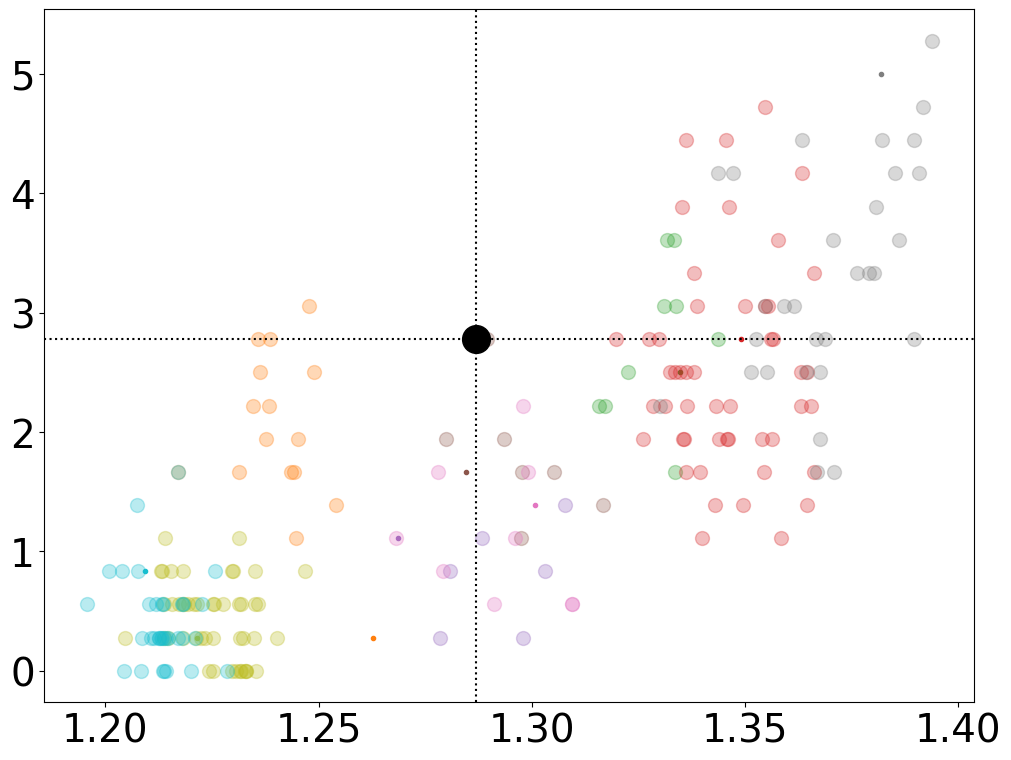

In [43]:
color_ls = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','k']
ny = 36#np.unique(u10.time.dt.year).shape[0]
ms = 20
wo_outliers = False
how_many = 2 # how many last models (outliers) to remove from regression
ols_calc = True
wls_calc = True

fig, ax = plt.subplots(figsize = (12,9))

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc', engine = 'netcdf4')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                elif  model == 'MPI-ESM1-2-LR-all-from1920':
                     ax.plot(mode,ns, marker = 'x', color = color, ms = 20)
                else:
                    ax.plot(mode,ns, marker = '.', color = color, ms = 20, alpha = 0.3)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        

#plt.legend()

CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            WLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     17.52
Date:                Thu, 25 Jan 2024   Prob (F-statistic):            0.00411
Time:                        00:06:42   Log-Likelihood:                -7.1928
No. Observations:                   9   AIC:                             18.39
Df Residuals:                       7   BIC:                             18.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


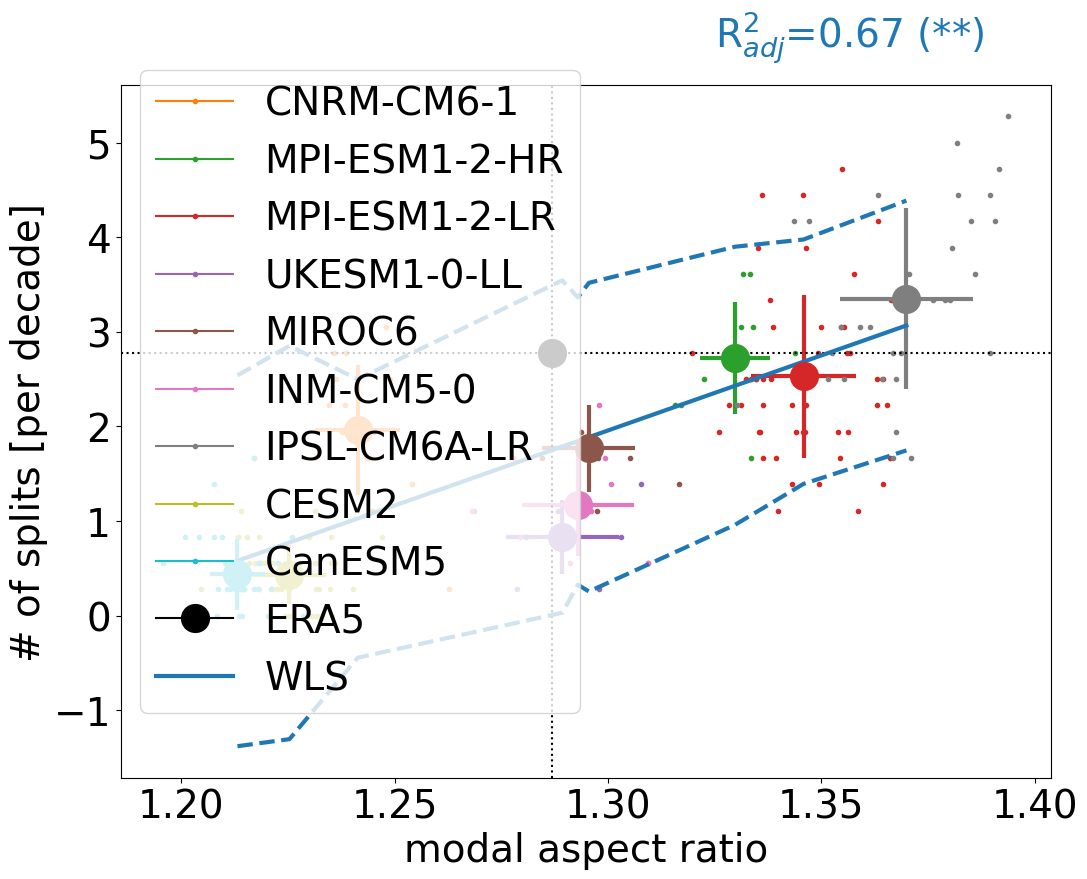

In [44]:
color_ls = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','k']
ny = 36#np.unique(u10.time.dt.year).shape[0]
ms = 20
wo_outliers = False
how_many = 2 # how many last models (outliers) to remove from regression
ols_calc = True
wls_calc = True

fig, ax = plt.subplots(figsize = (12,9))

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc', engine = 'netcdf4')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        
        x = np.mean(mode_ls)
        x_std = np.std(mode_ls)
        y= np.mean(ns_ls)
        y_std= np.std(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_std], coords = [('model', [model])]))
        #ax.plot(x,y, marker = 'o', color = color,ms = ms)
        ax.errorbar(
            x, y, yerr=y_std, xerr=x_std,
            ms = ms, color = color,
            marker='o',
            lw = 3,
        )

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    #ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    #plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    #plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    #print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    #ax.text(1.3,4.5,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(1.2,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    ax.text(1.325,6,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    print()
    print('outliers')
    print(results.summary().as_latex())
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(x[:-how_many][order],results.fittedvalues[order], label = f'OLS wo {how_many}', color = 'gray', lw = 3)
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(1.2,5.5,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')



ax.legend(loc='upper left', bbox_to_anchor=(0., 1.05))
plt.ylabel('# of splits [per decade]')
plt.xlabel('modal aspect ratio')
plt.savefig('split_frequency_vs_mode_MPI-ESMs.pdf',bbox_inches='tight')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'CNRM-CM6-1'),
  Text(1, 0, 'MPI-ESM1-2-HR'),
  Text(2, 0, 'MPI-ESM1-2-LR'),
  Text(3, 0, 'UKESM1-0-LL'),
  Text(4, 0, 'MIROC6'),
  Text(5, 0, 'INM-CM5-0'),
  Text(6, 0, 'IPSL-CM6A-LR'),
  Text(7, 0, 'CESM2'),
  Text(8, 0, 'CanESM5')])

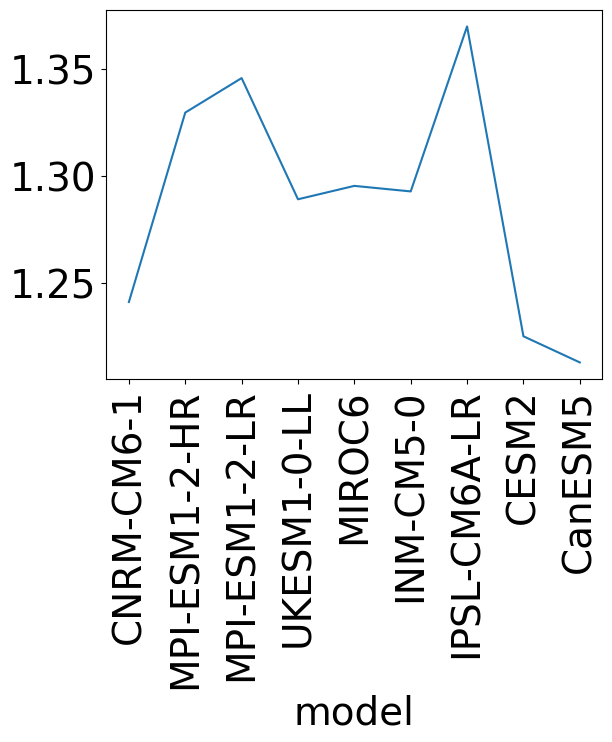

In [48]:
model_mode_da.plot()
plt.xticks(rotation = 90)

CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5

outliers
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.490   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.388   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     4.796   \\
\textbf{Date:}             & Thu, 25 Jan 2024 & \textbf{  Prob (F-statistic):} &   0.0801    \\
\textbf{Time:}             &     00:12:54     & \textbf{  Log-Likelihood:    } &   -6.1991   \\
\textbf{No. Observations:} &           7      & \textbf{  AIC:               } &     16.40   \\
\textbf{Df Residuals:}     &           5      & \textbf{  BIC:               } &     16.29   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                    

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


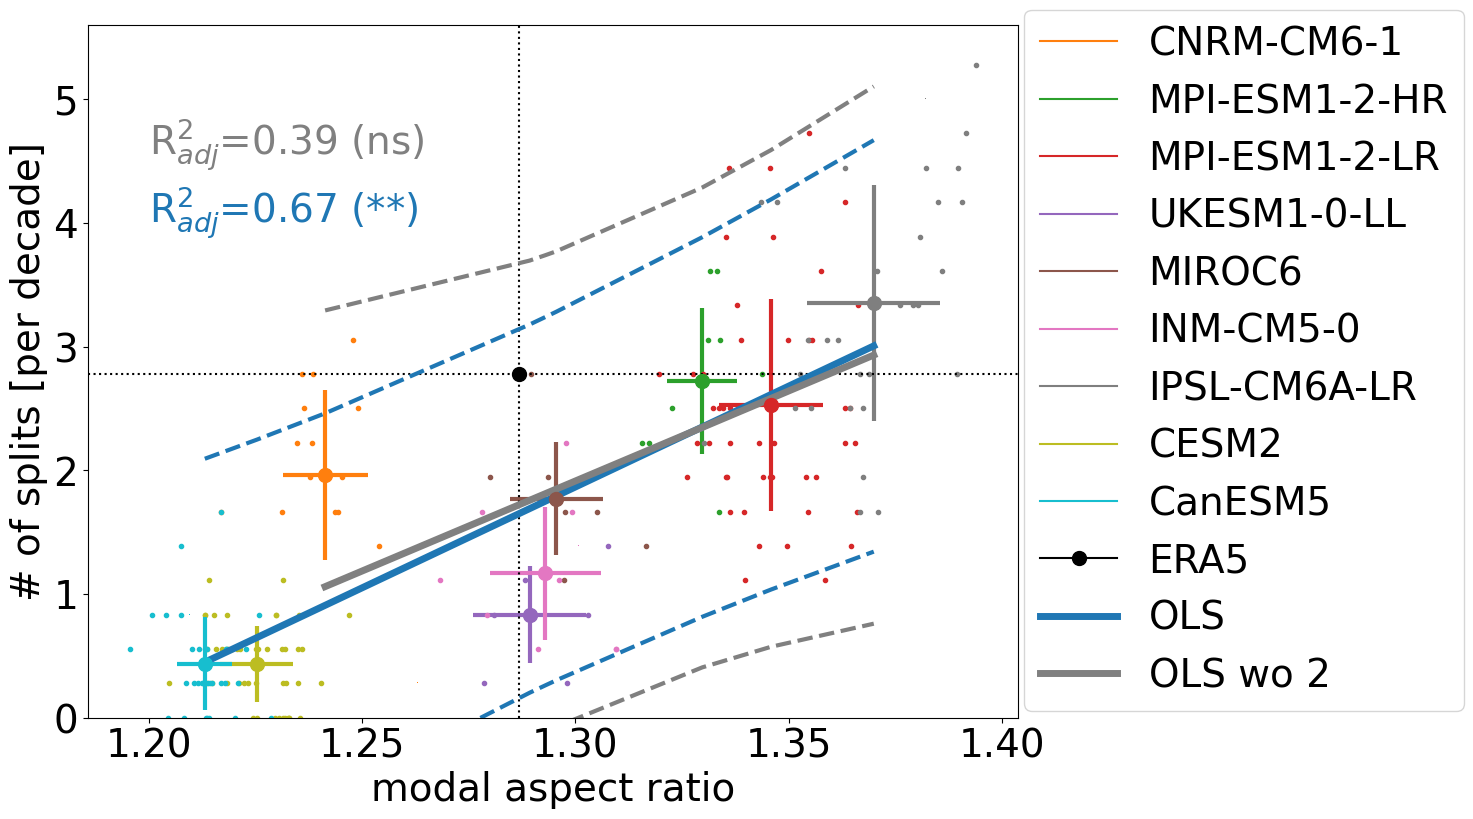

In [49]:
color_ls = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','k']
ny = 36#np.unique(u10.time.dt.year).shape[0]
ms = 10
wo_outliers = True
how_many = 2 # how many last models (outliers) to remove from regression
ols_calc = True
wls_calc = False

fig, ax = plt.subplots(figsize = (12,9))

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []

for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc', engine = 'netcdf4')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    if model ==  'MPI-ESM1-2-LR-all-from1920':
                        label =  'MPI-ESM1-2-LR'
                    else:
                        label = model
                    ax.plot(mode,ns, marker = ',', color = color, label = label)#, ms = ms)
                    #ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        
        x = np.mean(mode_ls)
        x_std = np.std(mode_ls)
        y= np.mean(ns_ls)
        y_std= np.std(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_std], coords = [('model', [model])]))
        ax.errorbar(
            x, y, yerr=y_std, xerr=x_std,
            ms = ms, color = color,
            marker='o',
            lw = 3,
        )

        #ax.plot(x,y, marker = 'o', color = color,ms = ms)
        


model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 5)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    #print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    #ax.text(1.2,4.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    ax.text(1.2,4.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(1.2,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    ax.text(1.225,6,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    print()
    print('outliers')
    print(results.summary().as_latex())
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(
        x[:-how_many][order],results.fittedvalues[order], 
        label = f'OLS wo {how_many}', color = 'gray', lw = 5)
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(1.2,4.55,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')


ax.set_ylim(bottom = 0)
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
plt.ylabel('# of splits [per decade]')
plt.xlabel('modal aspect ratio')
plt.savefig('split_frequency_vs_mode_with-compl-MPI-ESM-LR2-final.pdf',bbox_inches='tight')

In [ ]:
results.conf_int()

In [55]:
results.summary2()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.721  
Dependent Variable: y                AIC:                17.0228
Date:               2024-01-25 00:23 BIC:                17.4173
No. Observations:   9                Log-Likelihood:     -6.5114
Df Model:           1                F-statistic:        21.66  
Df Residuals:       7                Prob (F-statistic): 0.00233
R-squared:          0.756            Scale:              0.31995
------------------------------------------------------------------
         Coef.    Std.Err.      t      P>|t|     [0.025    0.975] 
------------------------------------------------------------------
const   76.7532    15.7815    4.8635   0.0018   39.4358   114.0706
x1      -0.9505     0.2042   -4.6539   0.0023   -1.4335    -0.4676
----------------------------------------------------------------
Omnibus:              2.516        Durbin-Watson:          1.602
Prob(Omnibus):        0.284        Jarque-Bera (JB):       0.712
Skew:                 -0.686       Prob(JB):               0.700
Kurtosis:             3.122        Condition No.:          6468 
================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [54]:
results.pvalues[-1]

0.0023312394203104537

# Displacements

CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.756   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.721   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     21.66   \\
\textbf{Date:}             & Thu, 25 Jan 2024 & \textbf{  Prob (F-statistic):} &  0.00233    \\
\textbf{Time:}             &     00:15:47     & \textbf{  Log-Likelihood:    } &   -6.5114   \\
\textbf{No. Observations:} &           9      & \textbf{  AIC:               } &     17.02   \\
\textbf{Df Residuals:}     &           7      & \textbf{  BIC:               } &     17.42   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &      

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


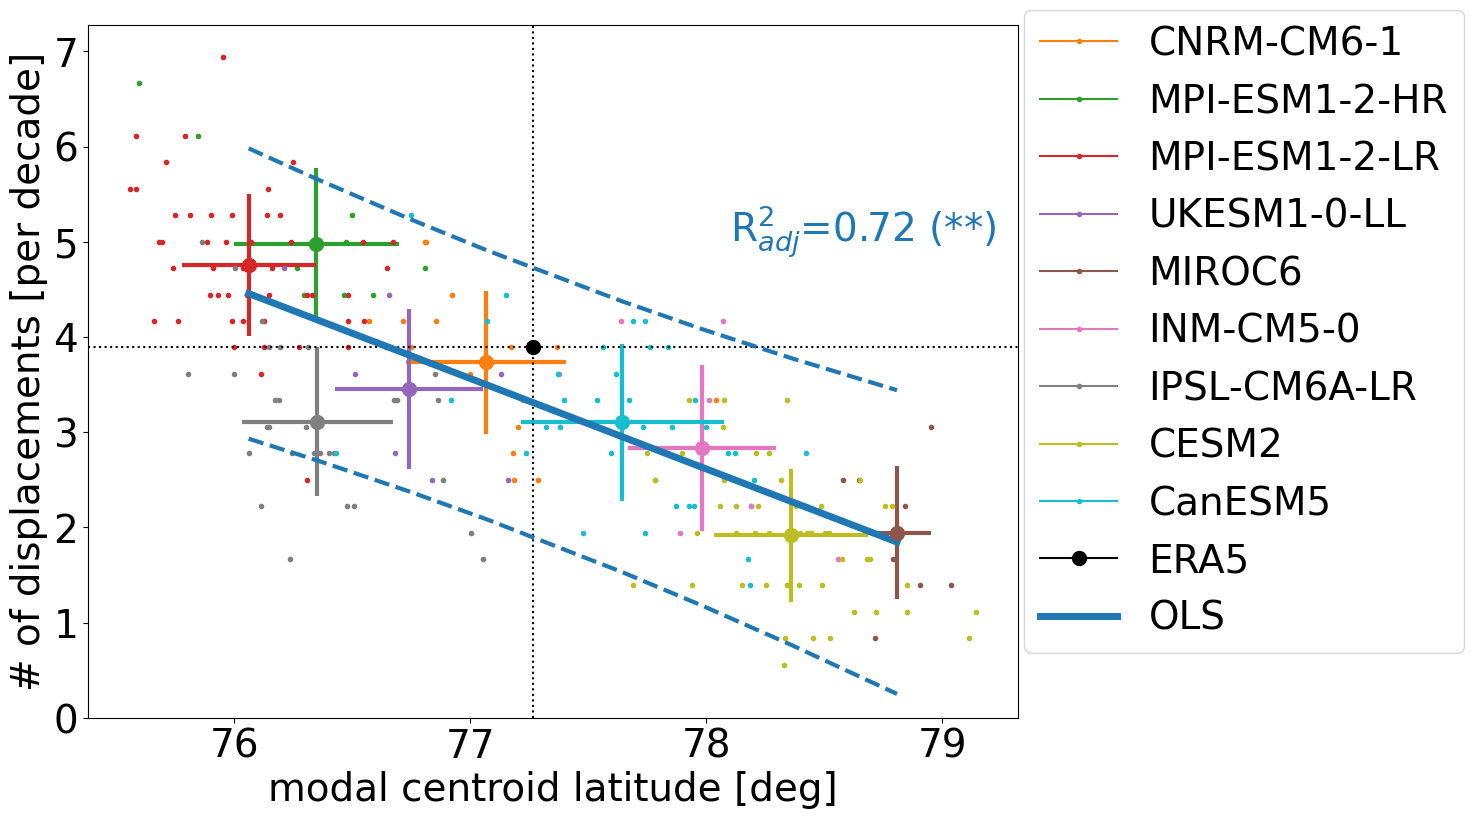

In [52]:
fig, ax = plt.subplots(figsize = (12,9))
wo_outliers = False

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_disp_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_latcent'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_disp_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_latcent'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        x = np.mean(mode_ls)
        x_std = np.std(mode_ls)
        y= np.mean(ns_ls)
        y_std = np.std(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        #model_ns_var_ls.append(xr.DataArray([y_var], coords = [('model', [model])]))
        #ax.plot(x,y, marker = 'o', color = color,ms = ms)
        ax.errorbar(
            x, y, yerr=y_std, xerr=x_std,
            ms = ms, color = color,
            marker='o',
            lw = 3,
        )

        

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
#model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 5)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    ax.text(78.1,5.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(78.9,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    #ax.text(78.5,7,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
    ax.text(78.9,7.,r"R$^{2}$="+f"{r2}", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(
        x[:-how_many][order],results.fittedvalues[order], 
        label = f'OLS wo {how_many}', color = 'gray', lw = 5
    )
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(78.1,5.55,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')
ax.set_ylim(bottom = 0)
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
plt.ylabel('# of displacements [per decade]')
plt.xlabel('modal centroid latitude [deg]')
plt.savefig('displacement_frequency_vs_mode_with-compl-MPI-ESM-LR2-final.pdf',bbox_inches='tight')

# both

<Axes: >

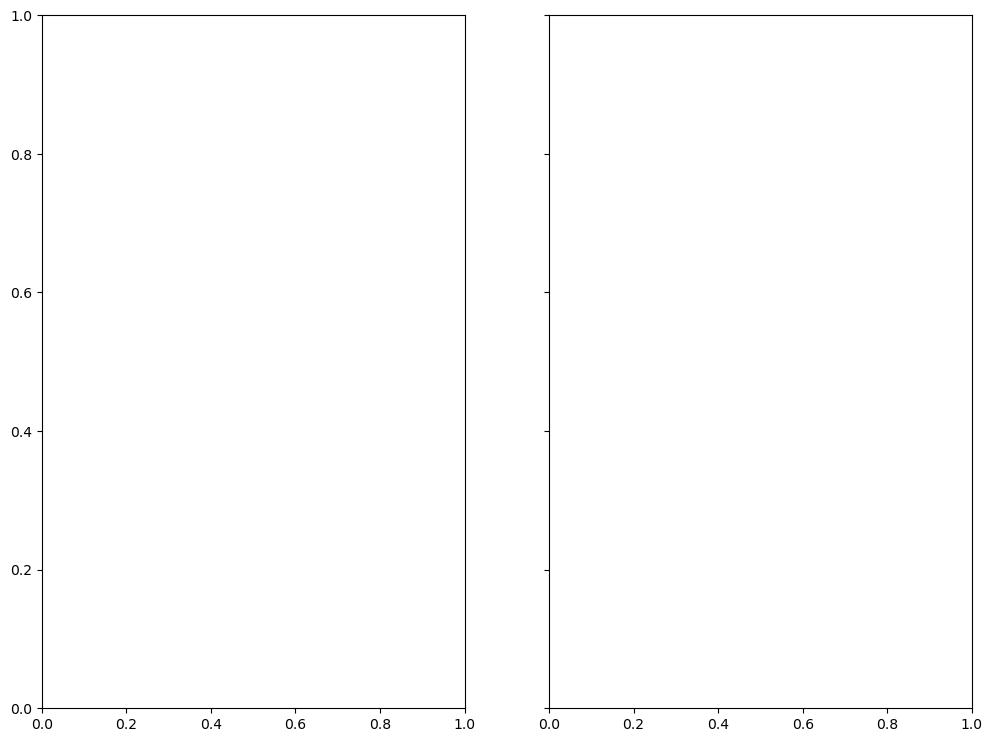

In [5]:
fig, axes = plt.subplots(figsize = (12,9), ncols = 2, sharey = True)
axes[0]

In [23]:
alpha = 0.317
np.array(stats.binom.interval(1-alpha,36,10/36))/36*10

array([1.94444444, 3.61111111])

In [26]:
ns/10

0.2777777777777778

In [27]:
10/ny

0.2777777777777778

In [30]:
ny*10

360

In [31]:
ns

2.7777777777777777

In [35]:
alpha = 0.317
np.array(stats.binom.interval(1-alpha,ny,ns/10.))/ny*10

array([1.94444444, 3.61111111])

CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5
CNRM-CM6-1
MPI-ESM1-2-HR
MPI-ESM1-2-LR
UKESM1-0-LL
MIROC6
INM-CM5-0
IPSL-CM6A-LR
CESM2
CanESM5
ERA5


/tmp/ipykernel_1059562/909722224.py:287: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


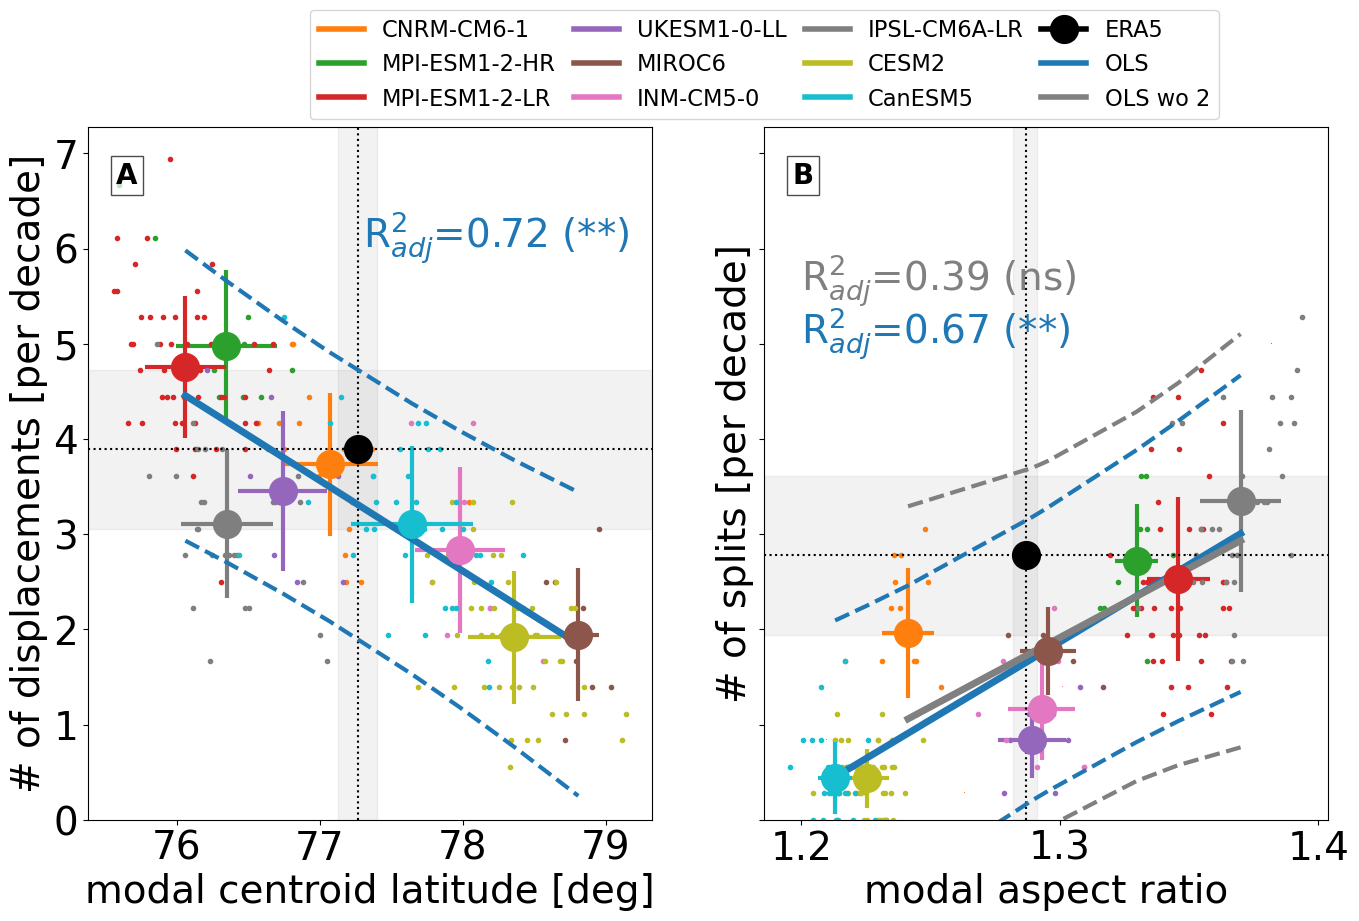

In [80]:
color_ls = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','k']
ms = 20
ny = 36
wo_outliers = False
ols_calc = True
wls_calc = False
alpha = 0.317

fig, axes = plt.subplots(figsize = (16,9), ncols = 2, sharey = True)

model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []

ax = axes[0]
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_disp_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_latcent'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
        #ax.fill_between()
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_disp_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_latcent'].sel(ens = ens).values
                if i == 1:
                    ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        x = np.mean(mode_ls)
        x_std = np.std(mode_ls)
        y= np.mean(ns_ls)
        y_std = np.std(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        #model_ns_var_ls.append(xr.DataArray([y_var], coords = [('model', [model])]))
        #ax.plot(x,y, marker = 'o', color = color,ms = ms)
        ax.errorbar(
            x, y, yerr=y_std, xerr=x_std,
            ms = ms, color = color,
            marker='o',
            lw = 3,
        )

        

model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
#model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)


# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 5)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    ax.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    ax.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    #print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    ax.text(77.3,6.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(78.9,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    #ax.text(78.5,7,r"R$^{2}$="+f"{r2} ({pv})", color = 'C0')
    ax.text(78.9,7.,r"R$^{2}$="+f"{r2}", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(
        x[:-how_many][order],results.fittedvalues[order], 
        label = f'OLS wo {how_many}', color = 'gray', lw = 5
    )
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(71.1,6.95,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


lower_th, upper_th = np.array(stats.binom.interval(1-alpha,ny,ns/10.))/ny*10
xlims = ax.get_xlim()
ax.fill_between(np.linspace(*xlims), y1=upper_th, y2=lower_th, color='gray',  interpolate=True, alpha=.1)
ax.set_xlim(*xlims)

ylims = ax.get_ylim()
ax.fill_betweenx(np.linspace(*ylims),77.12569550732209, 77.39958555069424, color='gray',  interpolate=True, alpha=.1)
ax.set_ylim(*ylims)
    
# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')
ax.set_ylim(bottom = 0)
#ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
ax.set_ylabel('# of displacements [per decade]')
ax.set_xlabel('modal centroid latitude [deg]')
ax.text(0.05, 0.95, ascii_uppercase[0], transform=ax.transAxes,
              fontsize=20, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})

wo_outliers = True
how_many = 2 # how many last models (outliers) to remove from regression
ols_calc = True
wls_calc = False


model_mode_ls = []
model_ns_ls = []
model_ns_var_ls = []

ax = axes[1]
for model, color in zip(model_ls_new, color_ls):
    print(model)
    ds_mode = xr.open_dataset(f'{out_dir}{model}_modes_nc', engine = 'netcdf4')   
    
    i = 0
   
    if model in ['ERA5']:
        split_dates=np.load(f'{out_dir}{model}_split_dates_all.npy',allow_pickle=True)
        ns = len(split_dates)/ny*10.
        mode = ds_mode['mode_aspect'].values
        ax.plot(mode,ns, marker = 'o', color = 'k', label = model, ms = ms)
        ax.axhline(ns,color = 'k', ls = ':' )
        ax.axvline(mode,color = 'k', ls = ':')
    else:
        ns_ls = []
        mode_ls = []
        for ens in ds_mode.ens.values:
            try:
                split_dates=np.load(f'{out_dir}{model}_{ens}_split_dates_all.npy',allow_pickle=True)
                i+=1
                ns = len(split_dates)/ny*10.
                mode = ds_mode['mode_aspect'].sel(ens = ens).values
                if i == 1:
                    if model ==  'MPI-ESM1-2-LR-all-from1920':
                        label =  'MPI-ESM1-2-LR'
                    else:
                        label = model
                    ax.plot(mode,ns, marker = ',', color = color, label = label)#, ms = ms)
                    #ax.plot(mode,ns, marker = '.', color = color, label = model)
                else:
                    ax.plot(mode,ns, marker = '.', color = color)
                ns_ls.append(ns)
                mode_ls.append(mode)
            except:
                pass
        #sys.exit()
        
        x = np.mean(mode_ls)
        x_std = np.std(mode_ls)
        y= np.mean(ns_ls)
        y_std= np.std(ns_ls)
        model_mode_ls.append(xr.DataArray([x], coords = [('model', [model])]))
        model_ns_ls.append(xr.DataArray([y], coords = [('model', [model])]))
        model_ns_var_ls.append(xr.DataArray([y_std], coords = [('model', [model])]))
        ax.errorbar(
            x, y, yerr=y_std, xerr=x_std,
            ms = ms, color = color,
            marker='o',
            lw = 3,
        )

        #ax.plot(x,y, marker = 'o', color = color,ms = ms)
        


model_mode_da = xr.concat(model_mode_ls, dim = 'model')
model_ns_da = xr.concat(model_ns_ls, dim = 'model')
model_ns_var_da = xr.concat(model_ns_var_ls, dim = 'model')

x = model_mode_da.values
x1 = sm.add_constant(np.column_stack(x).T) #  necessary, negative intercept is unphysical (frequancy of events cannot be <0)
y = model_ns_da.values
order = np.argsort(model_mode_da)



# OLS
if ols_calc:
    model_OLS = sm.OLS(y, x1)
    results = model_OLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'OLS', color = 'C0', lw = 5)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    ax.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    ax.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)      
    #print(results.summary().as_latex())
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[-1])#.round(3)
    #ax.text(1.2,4.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    ax.text(1.2,5.,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    #ax.text(1.2,4.5,r"R$^{2}_{adj}$="+f"{r2}", color = 'C0')

if wls_calc:
    model_WLS = sm.WLS(y, x1, weights=model_ns_var_da.values)
    results = model_WLS.fit()
    ax.plot(x[order],results.fittedvalues[order], label = 'WLS', color = 'C0', lw = 3)
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[order],iv_u[order], color = 'C0', ls="--", lw = 3)
    plt.plot(x[order],iv_l[order], color = 'C0',ls="--", lw = 3)     
    ax.text(1.225,6,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'C0')
    print(results.summary())

if wo_outliers:
    model_OLS = sm.OLS(y[:-how_many], x1[:-how_many])
    results = model_OLS.fit()
    #print()
    #print('outliers')
    #print(results.summary().as_latex())
    order = np.argsort(model_mode_da[:-how_many])
    ax.plot(
        x[:-how_many][order],results.fittedvalues[order], 
        label = f'OLS wo {how_many}', color = 'gray', lw = 5)
    
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    plt.plot(x[:-how_many][order],iv_u[order], color = 'gray', ls="--", lw = 3)
    plt.plot(x[:-how_many][order],iv_l[order], color = 'gray',ls="--", lw = 3)     
    
    r2 = results.rsquared_adj.round(2)
    pv = convert_pvalue_to_asterisks(results.pvalues[1])#.round(3)
    ax.text(1.2,5.55,r"R$^{2}_{adj}$="+f"{r2} ({pv})", color = 'gray')


# Theil-Sen
res = stats.theilslopes(y,x)
#ax.plot(x, res[1] + res[0] * x, 'r-', label = 'Theil-Sen')

lower_th, upper_th = np.array(stats.binom.interval(1-alpha,ny,ns/10.))/ny*10
xlims = ax.get_xlim()
ax.fill_between(np.linspace(*xlims), y1=upper_th, y2=lower_th, color='gray',  interpolate=True, alpha=.1)
ax.set_xlim(*xlims)

ylims = ax.get_ylim()
ax.fill_betweenx(np.linspace(*ylims),1.2820737387226975, 1.2913301865078577, color='gray',  interpolate=True, alpha=.1)
ax.set_ylim(*ylims)


ax.set_ylim(bottom = 0)
leg = ax.legend(loc='center', bbox_to_anchor=(0.0, 1.09), ncols = 4, columnspacing=0.8, fontsize = 'xx-small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)


ax.text(0.05, 0.95, ascii_uppercase[1], transform=ax.transAxes,
              fontsize=20, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})

ax.set_ylabel('# of splits [per decade]')
ax.set_xlabel('modal aspect ratio')
plt.savefig('both_frequency_vs_mode_with-compl-MPI-ESM-LR2-final.pdf',bbox_inches='tight')

In [77]:
ylims

(-0.08461757302608114, 7.279161683371613)

In [44]:
np.linspace(*ax.get_xlim())

array([1.18576447, 1.19021331, 1.19466215, 1.19911099, 1.20355983,
       1.20800867, 1.21245751, 1.21690635, 1.22135519, 1.22580403,
       1.23025287, 1.23470171, 1.23915055, 1.24359939, 1.24804823,
       1.25249707, 1.25694591, 1.26139475, 1.26584359, 1.27029244,
       1.27474128, 1.27919012, 1.28363896, 1.2880878 , 1.29253664,
       1.29698548, 1.30143432, 1.30588316, 1.310332  , 1.31478084,
       1.31922968, 1.32367852, 1.32812736, 1.3325762 , 1.33702504,
       1.34147388, 1.34592272, 1.35037156, 1.3548204 , 1.35926924,
       1.36371808, 1.36816692, 1.37261577, 1.37706461, 1.38151345,
       1.38596229, 1.39041113, 1.39485997, 1.39930881, 1.40375765])

In [38]:
x

array([1.24133675, 1.32973263, 1.34583436, 1.28927426, 1.29552944,
       1.29294193, 1.36994233, 1.22533791, 1.21314239])